In [40]:
import numpy as np
import pandas as pd
import plotnine as p9


from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve


In [41]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:

* age : Age of the patient

* sex : Sex of the patient

* cp : Chest Pain type

        - Value 0: asymptomatic
        
        - Value 1: typical angina
        
        - Value 2: atypical angina
        
        - Value 3: non-anginal pain
* trtbps : resting blood pressure (in mm Hg)

* chol : cholesterol in mg/dl fetched via BMI sensor

* restecg : resting electrocardiographic results

        - Value 0: normal
        
        - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        
        - Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
        
        - thalach : maximum heart rate achieved during exercise

* output : the doctor’s diagnosis of whether the patient is at risk for a heart attack

        - 0 = not at risk of heart attack
        
        - 1 = at risk of heart attack

In [42]:
display(ha.head())

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [43]:
display(ha.describe())

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [44]:
display(ha.nunique())

age         41
sex          2
cp           4
trtbps      48
chol       148
restecg      3
thalach     90
output       2
dtype: int64

In [45]:
# Null values per column
display(ha.isnull().sum())

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

In [46]:
RANDOM_STATE = 42
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [47]:
def bin_metrics(name, y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    roc  = roc_auc_score(y_true, y_proba)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} (CV out-of-fold) ===")
    print(f"ROC AUC: {roc}")
    print(f"Precision: {prec}")
    print(f"Recall (TPR): {rec}")
    print(f"Specificity (TNR): {spec}")
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    return {
        "roc": roc, "precision": prec, "recall": rec, "specificity": spec, "cm": cm
    }


In [48]:
def roc_df(y_true, y_proba, model_name):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        return pd.DataFrame({"FPR": fpr, "TPR": tpr, "Model": model_name})



In [49]:
def plot_roc_curves(curves_dict, title="ROC Curves (CV out-of-fold)"):
        """
        curves_dict: dict like {"KNN": y_proba_knn, "Logistic": y_proba_logit, "Tree": y_proba_tree}
        Assumes the same y_true for all (your training y).
        """
        # Build one long dataframe
        dfs = []
        for name, (y_true, y_proba) in curves_dict.items():
                dfs.append(roc_df(y_true, y_proba, name))
        df = pd.concat(dfs, ignore_index=True)

        plot = (
                p9.ggplot(df, p9.aes(x="FPR", y="TPR", color="Model"))
                + p9.geom_line(size=1.1)
                + p9.geom_abline(intercept=0, slope=1, linetype="dashed")
                + p9.coord_equal()
                + p9.labs(title=title, x="False Positive Rate", y="True Positive Rate")
                + p9.theme_minimal()
                + p9.theme(legend_position="bottom", figure_size=(6,5))
        )
        return plot

# Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.



In [50]:
X = ha.drop(columns=["output"])
y = ha["output"]

### Q1: KNN


In [51]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

In [52]:
knn_grid = {"clf__n_neighbors":[3,5,7,9,11], "clf__weights":["uniform","distance"]}
knn_cv = GridSearchCV(knn_pipe, knn_grid, scoring="roc_auc", cv=CV, n_jobs=-1)
knn_cv.fit(X, y)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'clf__n_neighbors': [3, 5, ...], 'clf__weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True



=== KNN (CV out-of-fold) ===
ROC AUC: 0.8292255420127277
Precision: 0.7388535031847133
Recall (TPR): 0.7945205479452054
Specificity (TNR): 0.6771653543307087
Confusion matrix (rows=true, cols=pred):
 [[ 86  41]
 [ 30 116]]


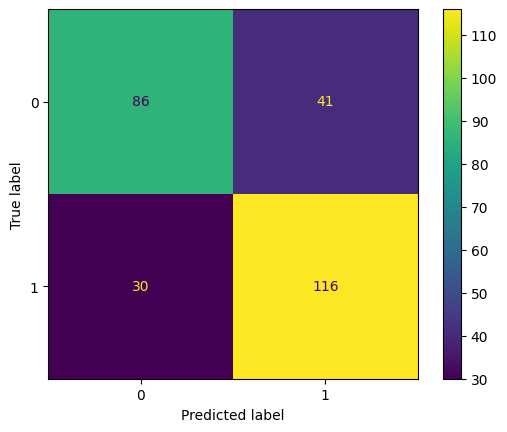

In [53]:
# CV out-of-fold probabilities for fair metrics/ROC
knn_oof = cross_val_predict(knn_cv.best_estimator_, X, y, cv=CV, method="predict_proba")[:,1]
_ = bin_metrics("KNN", y, knn_oof)
ConfusionMatrixDisplay.from_predictions(y, (knn_oof>=0.5).astype(int))



In [54]:
print("Best K:", knn_cv.best_params_)


Best K: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}


The KNN model got a ROC AUC of 0.83, meaning it’s good at telling who’s at risk or not.

It caught about 80% of real at-risk patients (recall) and was right 74% of the time when it said someone was at risk (precision).

It correctly identified 68% of safe patients (specificity).

The main issue is it missed 30 real cases (false negatives) and flagged 41 healthy ones (false positives).

Overall: solid model, but we’d like fewer missed cases.

### Q2: Logistic Regression


In [55]:
logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

In [56]:
logit_grid = {"clf__C":[0.1,1,3,10], "clf__penalty":["l2"], "clf__solver":["lbfgs","liblinear"]}
logit_cv = GridSearchCV(logit_pipe, logit_grid, scoring="roc_auc", cv=CV, n_jobs=-1)
logit_cv.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs', 'liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True



=== Logistic Regression (CV out-of-fold) ===
ROC AUC: 0.8503397691726889
Precision: 0.7828947368421053
Recall (TPR): 0.815068493150685
Specificity (TNR): 0.7401574803149606
Confusion matrix (rows=true, cols=pred):
 [[ 94  33]
 [ 27 119]]


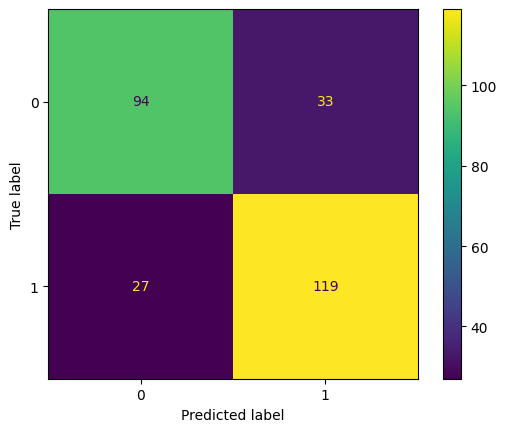

In [57]:
logit_oof = cross_val_predict(logit_cv.best_estimator_, X, y, cv=CV, method="predict_proba")[:,1]
_ = bin_metrics("Logistic Regression", y, logit_oof)
ConfusionMatrixDisplay.from_predictions(y, (logit_oof>=0.5).astype(int))

In [58]:
print("Best Logit params:", logit_cv.best_params_)


Best Logit params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


Logistic Regression performed best with a ROC AUC of 0.85.

It caught 81% of real cases, had 78% precision, and 74% specificity.

It made fewer mistakes than KNN - only 27 missed and 33 false alarms.

Overall: balanced, accurate, and the best all-around model.

### Q3: Decision Tree


In [59]:
tree_pipe = Pipeline([
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [60]:
tree_grid = {"clf__max_depth":[2,3,4,5,6,8,10], "clf__min_samples_leaf":[1,2,4], "clf__class_weight":[None,"balanced"]}
tree_cv = GridSearchCV(tree_pipe, tree_grid, scoring="roc_auc", cv=CV, n_jobs=-1)
tree_cv.fit(X, y)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__class_weight': [None, 'balanced'], 'clf__max_depth': [2, 3, ...], 'clf__min_samples_leaf': [1, 2, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'



=== Decision Tree (CV out-of-fold) ===
ROC AUC: 0.8129381943695395
Precision: 0.7906976744186046
Recall (TPR): 0.6986301369863014
Specificity (TNR): 0.7874015748031497
Confusion matrix (rows=true, cols=pred):
 [[100  27]
 [ 44 102]]


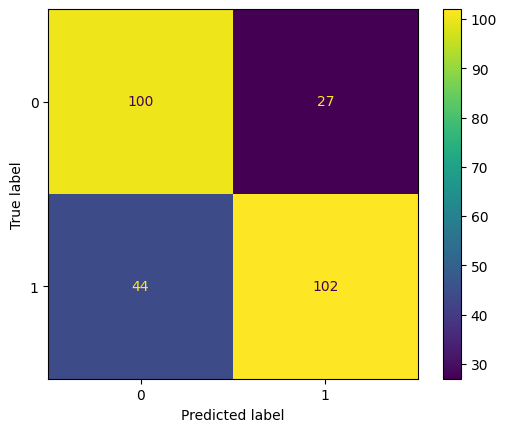

In [61]:
tree_oof = cross_val_predict(tree_cv.best_estimator_, X, y, cv=CV, method="predict_proba")[:,1]
_ = bin_metrics("Decision Tree", y, tree_oof)
ConfusionMatrixDisplay.from_predictions(y, (tree_oof>=0.5).astype(int))

In [62]:
print("Best Tree params:", tree_cv.best_params_)


Best Tree params: {'clf__class_weight': None, 'clf__max_depth': 3, 'clf__min_samples_leaf': 1}


The Decision Tree scored a ROC AUC of 0.81 - the lowest of the three.

It was most precise (79%) and specific (79%), but less sensitive (70% recall).

It missed 44 at-risk patients, which is concerning.

This model is careful but too conservative - it misses too many true cases.

### Q4: Interpretation
Which predictors were most important to predicting heart attack risk?

In [63]:
logit_coefs = pd.DataFrame({
    "Feature": X.columns,
    "Logit Coeff": logit_cv.best_estimator_.named_steps['clf'].coef_[0]
}).sort_values("Logit Coeff", ascending=False)

logit_coefs["odds_ratio"] = np.exp(logit_coefs["Logit Coeff"])
logit_coefs["Logit Coeff (odds ratio)"] = logit_coefs["Logit Coeff"].round(2).astype(str) + " (" + logit_coefs["odds_ratio"].round(2).astype(str) + ")"

tree_imp = pd.DataFrame({
    "Feature": X.columns,
    "Tree Importance": tree_cv.best_estimator_.named_steps['clf'].feature_importances_
})

importances = pd.merge(logit_coefs, tree_imp, on="Feature").sort_values("Tree Importance", ascending=False).drop(columns=["Logit Coeff", "odds_ratio"])

display(importances)

,Feature,Logit Coeff (odds ratio),Tree Importance
0,cp,0.69 (1.99),0.564630
4,age,-0.23 (0.79),0.151122
1,thalach,0.66 (1.93),0.112866
6,sex,-0.7 (0.5),0.099147
5,trtbps,-0.27 (0.76),0.072235
2,restecg,0.15 (1.16),0.000000
3,chol,-0.17 (0.84),0.000000


Both models agree on the key predictors:

Chest Pain Type (cp) - the biggest factor. More severe chest pain means higher risk.

Max Heart Rate (thalach) - higher values mean higher risk.

Age, Sex, Blood Pressure - smaller effects. Surprisingly, they show a slight negative link with risk here, possibly due to other interactions in the data.


### Q5: ROC Curve
Plot the ROC Curve for your three models above.

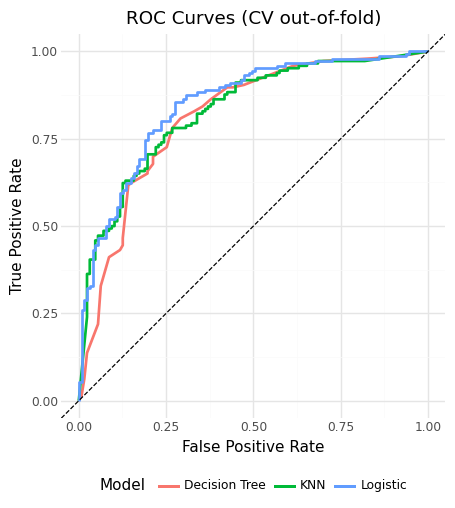

In [64]:
plot_roc_curves({
    "KNN": (y, knn_oof),
    "Logistic": (y, logit_oof),
    "Decision Tree": (y, tree_oof),
})


The ROC curve shows how well each model separates risky vs. safe patients:

Logistic Regression (AUC = 0.85): Best trade-off - top performer.

KNN (AUC = 0.83): Strong but slightly worse.

Decision Tree (AUC = 0.81): Good but least consistent.

The curve confirms Logistic Regression as the most reliable choice.

# Part Two: Metrics
Consider the following metrics:

**True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?

**Precision** or **Positive Predictive Value** = Of all the observations classified as Class A, how many of them were truly from Class A?

**True Negative Rate** or **Specificity** or **Negative Predictive Value** = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [65]:
def summarize(y_true, y_proba):
    y_pred = (y_proba>=0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return pd.Series({
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall (TPR)": recall_score(y_true, y_pred, zero_division=0),
        "Specificity (TNR)": tn/(tn+fp) if (tn+fp)>0 else 0.0
    })




In [66]:
metrics_summary = pd.DataFrame({
    "KNN": summarize(y, knn_oof),
    "Logistic": summarize(y, logit_oof),
    "Decision Tree": summarize(y, tree_oof)
}).T

display(metrics_summary)

,ROC AUC,Precision,Recall (TPR),Specificity (TNR)
KNN,0.829226,0.738854,0.794521,0.677165
Logistic,0.850340,0.782895,0.815068,0.740157
Decision Tree,0.812938,0.790698,0.698630,0.787402


# Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.



### Q1 The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

Use Recall to catch as many risky patients as possible.

Model: Logistic Regression (recall = 0.815).

Takeaway: Finds about 82% of at-risk cases, best for safety-critical use.

### Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Use Precision to avoid false alarms and save beds.

Model: Decision Tree (precision = 0.79) or Logistic Regression (0.78 with better balance).

Takeaway: Decision Tree if space is tight, Logistic Regression for balance.

### Q3 The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Focus on interpretability, not raw accuracy.

Model: Logistic Regression, easy to explain with clear coefficients.

Takeaway: Helps doctors understand which factors raise risk.

### Q4 The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Use ROC AUC as a benchmark of overall accuracy.

Model: Logistic Regression (AUC = 0.85).

Takeaway: Best model for comparing doctors’ diagnostic skill.

# Part Four: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

In [67]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [68]:
display(ha_validation.head())

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [69]:
display(ha_validation.describe())

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,54.533333,0.766667,0.900000,127.300000,240.833333,0.433333,151.466667,0.633333
std,8.451620,0.430183,1.061879,15.592107,44.962117,0.504007,19.842020,0.490133
min,40.000000,0.000000,0.000000,100.000000,131.000000,0.000000,111.000000,0.000000
25%,48.000000,1.000000,0.000000,113.500000,205.750000,0.000000,143.250000,0.000000
50%,54.500000,1.000000,0.500000,130.000000,245.000000,0.000000,155.000000,1.000000
75%,59.000000,1.000000,2.000000,139.500000,272.500000,1.000000,162.000000,1.000000
max,71.000000,1.000000,3.000000,160.000000,330.000000,1.000000,182.000000,1.000000


In [70]:
display(display(ha_validation.nunique()))

age        23
sex         2
cp          4
trtbps     16
chol       28
restecg     2
thalach    27
output      2
dtype: int64

None

In [71]:
# Null values per column
display(ha_validation.isnull().sum())

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

In [72]:
X_tr, y_tr = X, y
X_val = ha_validation.drop(columns=["output"])
y_val = ha_validation["output"]

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [73]:
final_knn   = knn_cv.best_estimator_.fit(X_tr, y_tr)
final_logit = logit_cv.best_estimator_.fit(X_tr, y_tr)
final_tree  = tree_cv.best_estimator_.fit(X_tr, y_tr)

In [74]:
def eval_val(name, model):
    proba = model.predict_proba(X_val)[:,1]
    yhat = (proba>=0.5).astype(int)
    cm = confusion_matrix(y_val, yhat)
    tn, fp, fn, tp = cm.ravel()
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    print(f"\n=== {name} (Validation) ===")
    print("ROC AUC:", roc_auc_score(y_val, proba))
    print("Precision:", precision_score(y_val, yhat, zero_division=0))
    print("Recall:", recall_score(y_val, yhat, zero_division=0))
    print("Specificity:", (spec))
    print("Confusion matrix:\n", cm)
    ConfusionMatrixDisplay.from_predictions(y_val, yhat)



=== KNN (Validation) ===
ROC AUC: 0.8851674641148326
Precision: 0.8666666666666667
Recall: 0.6842105263157895
Specificity: 0.8181818181818182
Confusion matrix:
 [[ 9  2]
 [ 6 13]]

=== Logistic (Validation) ===
ROC AUC: 0.9186602870813396
Precision: 0.9375
Recall: 0.7894736842105263
Specificity: 0.9090909090909091
Confusion matrix:
 [[10  1]
 [ 4 15]]

=== Decision Tree (Validation) ===
ROC AUC: 0.7775119617224879
Precision: 0.8
Recall: 0.631578947368421
Specificity: 0.7272727272727273
Confusion matrix:
 [[ 8  3]
 [ 7 12]]


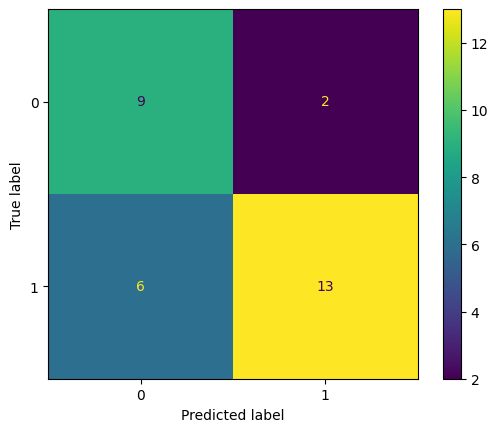

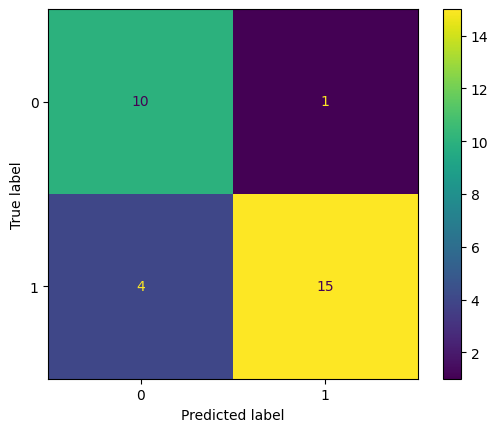

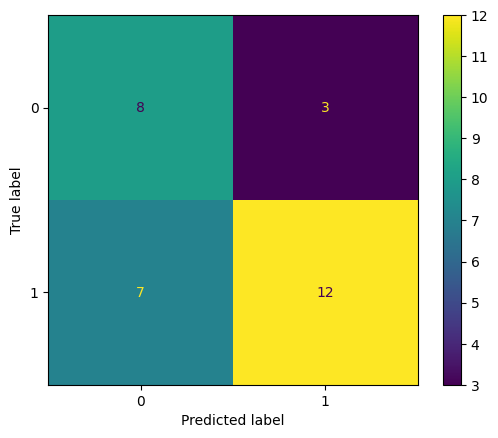

In [75]:
for nm, mdl in [("KNN", final_knn), ("Logistic", final_logit), ("Decision Tree", final_tree)]:
    eval_val(nm, mdl)

Validation confirmed our cross-validation results:

Logistic Regression: Even better (AUC = 0.92). Strong generalization.

KNN: Slightly lower recall but solid overall (AUC = 0.89).

Decision Tree: Slight drop (AUC = 0.78) - less stable.

Cross-validation gave accurate estimates - Logistic Regression remains the most dependable.

# Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [76]:
from sklearn.metrics import cohen_kappa_score


In [77]:
def kappa_of(y_true, y_proba, thr=0.5):
    y_pred = (y_proba>=thr).astype(int)
    return cohen_kappa_score(y_true, y_pred)

In [78]:
print("CV - KNN:", kappa_of(y, knn_oof))
print("CV - Logistic:", kappa_of(y, logit_oof))
print("CV - Tree:", kappa_of(y, tree_oof))

CV - KNN: 0.4743593220338984
CV - Logistic: 0.5569380578847715
CV - Tree: 0.4818349506776807


Kappa measures how much better the model’s predictions are than random guessing.

It’s useful when classes are imbalanced.

Our results:

Logistic Regression = 0.56

Decision Tree = 0.48

KNN = 0.47

The rankings match our earlier metrics, which makes sense since our data is balanced.

Takeaway: Logistic Regression is still best - Kappa confirms it.